# Краткое описание

В этом ноутбуке выполнено следующее:
- Загрузка и предобработка данных по криптовалютам - BTC, ETH, 4h.
- Вычисление тех. индикаторов и создание наборов признаков.
- Разделение данных на обучающую, валидационную и тестовую выборки.
- Подготовка датасетов для моделирования и сохранение в `output/`.
- Обучение и оценка моделей прогнозирования, сохранение предсказаний и метрик в `benchmarks_out/`.
- Вспомогательные скрипты для сбора данных находятся в `scripts/`.

Цель ноутбука: создать качественный бенчмарк на своих данных.


In [1]:
import os, sys, glob, math, json, time, gc
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import functools

import matplotlib.pyplot as plt

# проверка окружения
print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device count:", torch.cuda.device_count())
    print("GPU name:", torch.cuda.get_device_name(0))

Python: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
PyTorch: 2.5.1+cu121
CUDA available: True
CUDA device count: 1
GPU name: NVIDIA GeForce RTX 3050 Laptop GPU


In [ ]:
# один большой конфиг
class CFG:
    data_dir = "output" # папка с готовыми выборками
    context_len = 96 # длина окна истории
    horizon = 1 # Горизонт прогноза (кол-во четырехчасовых баров)
    stride = 1 # Шаг скольжения по окну
    batch_size = 256  # пока так
    num_workers = 0
    seed = 42
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Скалирование
    scale_features = True
    per_symbol_scaling = True

    # список моделей для запуска
    run_models = ["NaiveZero", "LSTM", "GRU", "TransGRU", "TFTLite"]

    # тренировка
    epochs = 25 # 8–12 - быстрый прогон, позже поставь 20-30 для финала
    lr = 1e-3
    weight_decay = 0.0
    grad_clip_norm = 1.0
    use_amp = True # AMP: смешанная точность на GPU — быстрее и экономит память

    # архитектуры
    d_model = 64 # ширина скрытых слоёв
    rnn_layers = 2
    dropout = 0.1
    nhead = 4 
    trans_layers = 2

    # Трейдинг-метрики
    # Авто‑порог и EMA‑сглаживание = меньше лишних сделок и комиссий.
    policy = "long_short"  # ["long_flat", "long_short"]
    thresh = 0.0 # порог, если больше нуля, то стратегия будет консервативной
    fee_bps = 3 # комиссия
    bars_per_day_guess = 24 // 4 
    days_per_year = 365
    returns_kind = "log"
    # настройка доп. потерь на направление
    use_sign_loss = True
    sign_loss_alpha = 0.1
    sign_loss_scale = 25.0
    # порог и сглаживание торгового сигнала
    thresh_kind = "auto"  # 'fixed' или 'auto'
    thresh_k = 0.2            # множитель для std(y_pred) при авто-пороге
    policy_smooth_alpha = 0.2 # EMA сглаживание предикта, 0 отключает
    num_strategies = 1
    # Валидация
    use_walkforward = False
    embargo_bars = 0
    # Диагностика и исследования
    run_tftlite_ablation = False
    dm_loss = "mae"  # 'mae' или 'mse' для DM-теста

    # колонки, на деле будут автодетектиться, но тут просто подсказки/ключевые слова
    known_keys = ["hour", "day_of_week", "dow", "hour_sin", "hour_cos", "dow_sin", "dow_cos"]
    time_col_candidates = ["datetime", "date", "timestamp"]
    symbol_col_candidates = ["symbol", "ticker", "asset"]
    target_col_candidates = ["y", "target", "ret_t+1", "y_next", "target_next"]
    retlog_col_candidates = ["ret_log", "log_ret", "return_log"]
    gap_col_keywords = ["gap", "is_gap", "gap_hours", "dt_gap"]

cfg = CFG()

In [3]:
# утилиты, сиды, метрики и т.д.

def seed_everything(seed: int = 42):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(cfg.seed)

def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))

def smape(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.maximum(denom, eps)
    return float(np.mean(np.abs(y_pred - y_true) / denom) * 100.0)

def r2_score(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return float(1.0 - ss_res / ss_tot) if ss_tot > 0 else 0.0

def corrcoef(y_true, y_pred):
    a = np.asarray(y_true); b = np.asarray(y_pred)
    if a.std() < 1e-12 or b.std() < 1e-12:
        return 0.0
    return float(np.corrcoef(a, b)[0,1])

def hitrate(y_true, y_pred):
    a = np.asarray(y_true); b = np.asarray(y_pred)
    return float(np.mean(np.sign(a) == np.sign(b)))

def equity_curve(returns): #returns - последовательность арифметических доходностей
    eq = np.cumprod(1.0 + returns)
    return eq

def max_drawdown(equity):
    peak = np.maximum.accumulate(equity)
    dd = (equity - peak) / np.maximum(peak, 1e-12)
    mdd = dd.min()
    return float(mdd), dd

def annualized_shape(returns, bars_per_year):
    r = np.array(returns)
    mu = r.mean()
    sd = r.std(ddof=1)
    if sd < 1e-12:
        return 0.0
    return float((mu/sd)*math.sqrt(bars_per_year))

def calmar_ratio(returns, bars_per_year): #годовая доходность по средней лог-доходности
    r = np.asarray(returns)
    mean_log=np.log1p(r).mean()
    ann_ret=math.expm1(mean_log*bars_per_year)
    eq=equity_curve(r)
    mdd, _ = max_drawdown(eq)
    if mdd >= 0: #не было просадок
        return float('inf')
    return float(ann_ret/abs(mdd))

# === Новые метрики и тесты: NaiveRW, MASE, DM-test, PT-test, PSR/DSR ===
def naive_rw_forecast(times: np.ndarray, sym_id: np.ndarray, y_true: np.ndarray) -> np.ndarray:
    # Предсказываем y_t как y_{t-1} внутри каждого символа
    df = pd.DataFrame({"time": pd.to_datetime(times), "sym_id": sym_id.astype(int), "y_true": y_true.astype(np.float64)})
    df = df.sort_values(["sym_id", "time"])
    df["y_pred_rw"] = df.groupby("sym_id")["y_true"].shift(1).fillna(0.0)
    # Восстановим исходный порядок
    df = df.sort_index()
    return df["y_pred_rw"].to_numpy().astype(np.float64)

def mase(y_true: np.ndarray, y_pred: np.ndarray, baseline_pred: np.ndarray) -> float:
    mae_model = float(mean_absolute_error(y_true, y_pred))
    mae_base = float(mean_absolute_error(y_true, baseline_pred))
    return float(mae_model / max(mae_base, 1e-12))

def errors_mae(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    return np.abs(y_true - y_pred).astype(np.float64)

def errors_rmse(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    return (y_true - y_pred).astype(np.float64)**2

def dm_test(e_model: np.ndarray, e_base: np.ndarray) -> Tuple[float, float]:
    # Упрощённый DM-тест (h=1): сравнение средних потерь
    d = (e_model - e_base).astype(np.float64)
    T = len(d)
    if T < 3:
        return 0.0, 1.0
    dbar = float(np.mean(d))
    s2 = float(np.var(d, ddof=1))
    if s2 < 1e-16:
        return 0.0, 1.0
    stat = dbar / math.sqrt(s2 / T)
    # двусторонняя p-value по нормальному приближению
    p = 2.0 * (1.0 - 0.5 * (1.0 + math.erf(abs(stat) / math.sqrt(2))))
    return float(stat), float(p)

def pesaran_timmermann(y_true: np.ndarray, y_pred: np.ndarray, n_perm: int = 0) -> float:
    # Перестановочный тест независимости направлений (по-умолчанию закрытая форма)
    a = np.sign(y_true).astype(int)
    b = np.sign(y_pred).astype(int)
    n = len(a)
    if n < 3:
        return 1.0
    p1 = float(np.mean(a > 0))
    q1 = float(np.mean(b > 0))
    hit = float(np.mean(a == b))
    p0 = p1 * q1 + (1 - p1) * (1 - q1)
    # нормальное приближение дисперсии под независимостью
    var0 = p0 * (1 - p0)
    if var0 <= 1e-16:
        return 1.0
    z = (hit - p0) / math.sqrt(var0 / n)
    p = 2.0 * (1.0 - 0.5 * (1.0 + math.erf(abs(z) / math.sqrt(2))))
    return float(p)

def psr(returns: np.ndarray, sr0: float = 0.0) -> float:
    r = np.asarray(returns, dtype=np.float64)
    r = r[np.isfinite(r)]
    n = len(r)
    if n < 5:
        return 0.5
    mu = float(np.mean(r))
    sd = float(np.std(r, ddof=1))
    if sd < 1e-12:
        return 0.5
    S = mu / sd
    z = (S - sr0) * math.sqrt(n - 1)
    # поправка Ло с учётом асимметрии и эксцесса
    x = (r - mu) / sd
    gamma3 = float(np.mean(x**3))
    gamma4 = float(np.mean(x**4))
    denom = math.sqrt(max(1e-12, 1 - gamma3 * S + ((gamma4 - 1) / 4.0) * (S**2)))
    z_adj = z / denom
    p = 0.5 * (1.0 + math.erf(z_adj / math.sqrt(2)))
    return float(p)

def dsr(returns: np.ndarray, sr0: float = 0.0, num_strats: int = 1) -> float:
    # Без информации о множественном тестировании оставляем DSR как PSR
    if num_strats <= 1:
        return psr(returns, sr0=sr0)
    # При num_strats>1 можно добавить дефляцию по Bailey, здесь proxy как PSR
    return psr(returns, sr0=sr0)

# Санитарные чеки (shift-invariance) и leak-detector
def shift_invariance_check(df: pd.DataFrame, sym_col: Optional[str], feature_cols: List[str], y_col: str, max_shift: int = 3) -> pd.DataFrame:
    rows = []
    if sym_col is None:
        groups = [("__single__", df)]
    else:
        groups = list(df.groupby(sym_col))
    for s, g in groups:
        g = g.copy()
        for sh in range(1, max_shift+1):
            y = g[y_col].to_numpy()
            for c in feature_cols:
                x = g[c].shift(sh).to_numpy()
                mask = np.isfinite(x) & np.isfinite(y)
                if mask.sum() < 10:
                    continue
                r = np.corrcoef(x[mask], y[mask])[0,1] if np.std(x[mask])>1e-12 and np.std(y[mask])>1e-12 else 0.0
                rows.append({"sym": s, "feature": c, "shift": sh, "corr": float(r)})
    return pd.DataFrame(rows)

def leak_detector_target_shuffling(df: pd.DataFrame, sym_col: Optional[str], feature_cols: List[str], y_col: str, n_repeats: int = 5) -> float:
    # Перемешиваем таргет внутри символов и меряем R^2 простого линейного регрессиона
    from sklearn.linear_model import Ridge
    rng = np.random.default_rng(cfg.seed)
    scores = []
    if sym_col is None:
        groups = [("__single__", df)]
    else:
        groups = list(df.groupby(sym_col))
    for _ in range(n_repeats):
        parts = []
        for s, g in groups:
            g = g.copy()
            y = g[y_col].to_numpy()
            rng.shuffle(y)
            g[y_col] = y
            parts.append(g)
        d = pd.concat(parts).sort_values(df.columns[0])
        X = d[feature_cols].to_numpy().astype(np.float32)
        y = d[y_col].to_numpy().astype(np.float32)
        model = Ridge(alpha=1.0)
        model.fit(X, y)
        yhat = model.predict(X)
        scores.append(r2_score(y, yhat))
    return float(np.mean(scores))

# Walk-forward фолды с эмбарго
def make_walkforward_folds(df: pd.DataFrame, sym_col: Optional[str], t_col: str, n_folds: int = 4, train_ratio: float = 0.7, embargo_bars: int = 0) -> List[Tuple[np.ndarray, np.ndarray]]:
    df = df.sort_values([sym_col, t_col]) if sym_col is not None else df.sort_values(t_col)
    idx = np.arange(len(df))
    folds = []
    split_points = np.linspace(0, len(df), n_folds+1, dtype=int)
    for k in range(n_folds):
        a, b = split_points[k], split_points[k+1]
        mid = a + int((b - a) * train_ratio)
        train_idx = idx[a:mid]
        test_idx = idx[min(mid + embargo_bars, b):b]
        if len(train_idx) > 0 and len(test_idx) > 0:
            folds.append((train_idx, test_idx))
    return folds

# Мини-абляция для TFTLite
def tftlite_ablation_configs(base_cfg: CFG) -> List[Dict]:
    runs = []
    runs.append({"name": "TFTLite_A", "params": {}})
    runs.append({"name": "TFTLite_B", "params": {"context_len": max(12, base_cfg.context_len//2)}})
    runs.append({"name": "TFTLite_C", "params": {"dropout": min(0.5, base_cfg.dropout + 0.2)}})
    runs.append({"name": "TFTLite_D", "params": {"d_model": base_cfg.d_model * 2}})
    return runs

def run_walkforward(all_df: pd.DataFrame, feature_cols: List[str], known_cols: List[str], sym_col: Optional[str], n_folds: int = 4, train_ratio: float = 0.7, embargo_bars: int = 0):
    t_col = _detect_timecol(all_df)
    folds = make_walkforward_folds(all_df, sym_col, t_col, n_folds=n_folds, train_ratio=train_ratio, embargo_bars=embargo_bars)
    results, pred_store = [], {}
    for fold_id, (train_idx, test_idx) in enumerate(folds):
        tr = all_df.iloc[train_idx].copy()
        te = all_df.iloc[test_idx].copy()
        v_size = max(1, int(0.1 * len(tr)))
        va = tr.iloc[-v_size:].copy(); tr2 = tr.iloc[:-v_size].copy()
        scalers = fit_scalers(tr2, sym_col, feature_cols)
        tr2 = apply_scalers(tr2, sym_col, feature_cols, scalers)
        va = apply_scalers(va, sym_col, feature_cols, scalers)
        te = apply_scalers(te, sym_col, feature_cols, scalers)
        symbol_vocab = make_symbol_vocab(tr2, va, te, sym_col=sym_col)
        ds_train, ds_valid, ds_test, dl_train, dl_valid, dl_test = make_loaders(tr2, va, te, feature_cols, known_cols, "y", sym_col, symbol_vocab)
        id2sym = {i:s for i,s in enumerate(symbol_vocab)}
        for name in cfg.run_models:
            print("="*80)
            print(f"Fold {fold_id+1}/{len(folds)} — Model: {name}")
            if name == "NaiveZero":
                class Dummy(nn.Module):
                    def forward(self, x): return x
                model = Dummy()
                optim = torch.optim.Adam([torch.zeros(1, requires_grad=True)], lr=cfg.lr)
            elif name == "LSTM":
                model = LSTMRegressor(input_dim=len(feature_cols), d_model=cfg.d_model, num_layers=cfg.rnn_layers, dropout=cfg.dropout)
                optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
            elif name == "GRU":
                model = GRURegressor(input_dim=len(feature_cols), d_model=cfg.d_model, num_layers=cfg.rnn_layers, dropout=cfg.dropout)
                optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
            elif name == "TransGRU":
                model = TransGRU(input_dim=len(feature_cols), d_model=cfg.d_model, nhead=cfg.nhead, num_layers=cfg.trans_layers, rnn_layers=1, dropout=cfg.dropout)
                optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
            elif name == "TFTLite":
                obs_cols = [c for c in feature_cols if c not in known_cols]
                known_cols_in = [c for c in known_cols if c in feature_cols]
                n_symbols = len(symbol_vocab)
                model = TFTLite(obs_dim=len(obs_cols), known_dim=len(known_cols_in), n_symbols=n_symbols, d_model=cfg.d_model, nhead=cfg.nhead, rnn_layers=1, dropout=cfg.dropout)
                optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
            else:
                raise ValueError(name)
            meta, reg_metrics = train_eval_model(name, model, dl_train, dl_valid, dl_test, optim)
            trade_metrics = trading_metrics_portfolio(meta, id2sym, policy=cfg.policy, thresh=("auto" if cfg.thresh_kind == "auto" else cfg.thresh), fee_bps=cfg.fee_bps, bars_per_year=None, returns_kind=cfg.returns_kind)
            row = {"fold": fold_id, "model": name, **reg_metrics, **trade_metrics}
            results.append(row)
            pred_store.setdefault(name, []).append({"fold": fold_id, "time": pd.to_datetime(meta["time"]).astype(str).tolist(), "sym_id": meta["sym_id"].astype(int).tolist(), "y_true": meta["y_true"].tolist(), "y_pred": meta["y_pred"].tolist()})
    return pd.DataFrame(results), pred_store


In [4]:
def _find_column(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand in lower:
            return lower[cand]
    for c in df.columns:
        lc = c.lower()
        if any(cand in lc for cand in candidates):
            return c
    return None

def _detect_timecol(df):
    c = _find_column(df, cfg.time_col_candidates)
    if c is None:
        raise ValueError("Не найден столбец времени")
    return c

def _detect_symbolcol(df):
    return _find_column(df, cfg.symbol_col_candidates)

def _detect_targetcol(df):
    return _find_column(df, cfg.target_col_candidates)

def _detect_gapcols(df):
    cols = []
    for c in df.columns:
        lc = c.lower()
        for key in cfg.gap_col_keywords:
            if key in lc:
                cols.append(c); break
    return cols

def load_split_df(split: str) -> pd.DataFrame:
    pattern = os.path.join(cfg.data_dir, f"*_{split}.csv")
    files = sorted(glob.glob(pattern))
    if not files:
        pattern2 = os.path.join(cfg.data_dir, f"*{split}*.csv")
        files = sorted(glob.glob(pattern2))
    if not files:
        raise FileNotFoundError(f"Не найдены файлы для сплита '{split}' в {cfg.data_dir}")
    dfs = []
    for f in files:
        df = pd.read_csv(f)
        dfs.append(df)
    df = pd.concat(dfs, axis=0, ignore_index=True)
    tcol = _detect_timecol(df)
    df[tcol] = pd.to_datetime(df[tcol], errors="coerce", utc=True)
    # Сортируем по символу и времени, чтобы окна шли строго по каждому активу
    scol = _detect_symbolcol(df)
    if scol is not None:
        df = df.sort_values([scol, tcol]).reset_index(drop=True)
    else:
        df = df.sort_values(tcol).reset_index(drop=True)
    return df

def infer_bars_per_year_from_df(df: pd.DataFrame) -> int:
    #считаем по каждому символу и берём медиану
    tcol = _detect_timecol(df)
    scol = _detect_symbolcol(df)
    secs = []
    if scol is not None:
        for _, g in df.groupby(scol):
            t = pd.to_datetime(g[tcol], errors="coerce").dropna().values.astype("datetime64[s]")
            if len(t) < 3: 
                continue
            d = np.diff(t).astype("timedelta64[s]").astype(int)
            if len(d) > 0:
                secs.append(int(np.median(d)))
    else:
        t = pd.to_datetime(df[tcol], errors="coerce").dropna().values.astype("datetime64[s]")
        if len(t) >= 3:
            d = np.diff(t).astype("timedelta64[s]").astype(int)
            if len(d) > 0:
                secs.append(int(np.median(d)))
    if not secs:
        return cfg.days_per_year * cfg.bars_per_day_guess
    med_sec = int(np.median(secs))
    if med_sec <= 0:
        return cfg.days_per_year * cfg.bars_per_day_guess
    bars_per_day = int(round(24*3600 / med_sec))
    return bars_per_day * cfg.days_per_year


In [5]:
# Подготовка фич/таргета, скейлинг, построение последовательностей

def prepare_xy(df: pd.DataFrame) -> Tuple[pd.DataFrame, str, Optional[str], List[str], List[str]]:
    # Возвращает df - уже с целевой колонкой y без пропусков по ней
    # y_col - имя целевой, symbol_col - имя колонки символа или none,
    # known_cols - список известных признаков, drop_cols - кандидаты на исключение из X (время, флаги и т.д.)

    tcol = _detect_timecol(df)
    symcol = _detect_symbolcol(df)
    ycol = _detect_targetcol(df)

    # если явного таргета нет, строим из ret_log.shift(-horizon)
    if ycol is None:
        ret_col = _find_column(df, cfg.retlog_col_candidates)
        if ret_col is None:
            raise ValueError("Не найден target и нет ret_log для shift(-horizon).")
        df = df.copy()
        df["y"] = df[ret_col].shift(-cfg.horizon)
        ycol = "y"
    else:
        if ycol != "y":
            df = df.rename(columns={ycol: "y"})
            ycol = "y"
    
    #сортировка уже была; просто удаляем NaN по y (это и срежет хвост)
    df = df.dropna(subset=["y"]).reset_index(drop=True)
    
    # gap-строки: по умолчанию фильтруем
    gap_cols = _detect_gapcols(df)
    if gap_cols:
        mask_ok = np.ones(len(df), dtype=bool)
        for gc in gap_cols:
            bad = (pd.to_numeric(df[gc], errors="coerce").fillna(0).values != 0).astype(bool)
            if df[gc].dtype == bool:
                bad |= df[gc].values.astype(bool)
            mask_ok &= ~bad
        before = len(df)
        df = df.loc[mask_ok].copy().reset_index(drop=True)
        after = len(df)
        print(f"удалено строк по флагам разрывов ({gap_cols}): {before - after}")
    else:
        print("Разрывов в колонках не найдено, пропускаем фильтрацию по gap")

    known_cols = []
    for c in df.columns:
        lc = c.lower()
        for key in cfg.known_keys:
            if key in lc and c not in ["y", tcol, symcol]:
                known_cols.append(c)
                break

    drop_cols = [tcol, "y"]
    if symcol is not None:
        drop_cols.append(symcol)
    drop_cols.extend(_detect_gapcols(df))
    drop_cols = list(dict.fromkeys([c for c in drop_cols if c in df.columns]))

    return df, "y", symcol, known_cols, drop_cols
    

def fit_scalers(train_df: pd.DataFrame, symcol: Optional[str], feature_cols: List[str]) -> Dict:
    scalers = {}
    if not cfg.scale_features:
        return scalers
    # обучаем на float32
    train_vals = train_df[feature_cols].astype(np.float32)
    if cfg.per_symbol_scaling and symcol is not None:
        for sym, g in train_vals.join(train_df[symcol]).groupby(symcol):
            ss = StandardScaler()
            ss.fit(g[feature_cols].values)
            scalers[sym] = ss
    else:
        ss = StandardScaler()
        ss.fit(train_vals.values)
        scalers["__global__"] = ss
    return scalers

def apply_scalers(df: pd.DataFrame, symcol: Optional[str], feature_cols: List[str], scalers: Dict) -> pd.DataFrame:
    if not scalers:
        return df
    df = df.copy()
    X = df[feature_cols].astype(np.float32).values
    if "__global__" in scalers:
        X_scaled = scalers["__global__"].transform(X).astype(np.float32)
        df[feature_cols] = pd.DataFrame(X_scaled, index=df.index, columns=feature_cols)
        return df
    if symcol is None:
        first_key = list(scalers.keys())[0]
        X_scaled = scalers[first_key].transform(X).astype(np.float32)
        df[feature_cols] = pd.DataFrame(X_scaled, index=df.index, columns=feature_cols)
        return df
    parts = []
    for sym, g in df.groupby(symcol):
        ss = scalers.get(sym, None)
        if ss is None:
            ss = scalers[list(scalers.keys())[0]]
        Xg = g[feature_cols].astype(np.float32).values
        sg = pd.DataFrame(ss.transform(Xg).astype(np.float32), index=g.index, columns=feature_cols)
        parts.append(sg)
    X_scaled = pd.concat(parts).sort_index()
    df[feature_cols] = X_scaled
    return df

In [ ]:
# датасеты для последовательностей
class SeqDataset(Dataset):
    # Возвращает окна по каждому символу, вместе с метаданными
    # "x_all_past - [B, L, D_all] для LSTM/GRU/TransGRU
    # "x_past_obs" - [B, L, D_obs] для TFT-lite
    # "x_past_known" - B, L, D_known]
    # "x_future_known" - [B, H, D_known]
    # "sym_id" - [B] - индекс символа
    # "time" - [B], - метка времени целевого шага

    def __init__(self,
                 df: pd.DataFrame,
                 feature_cols: List[str],
                 known_cols: List[str],
                 y_col: str,
                 symcol: Optional[str],
                 context_len: int,
                 horizon: int,
                 stride: int = 1,
                 symbol_vocab: Optional[List[str]] = None):
        super().__init__()
        self.context_len = context_len
        self.horizon = horizon
        self.stride = stride
        self.feature_cols = feature_cols
        self.known_cols = [c for c in known_cols if c in feature_cols]
        self.obs_cols = [c for c in feature_cols if c not in self.known_cols]
        self.y_col = y_col
        self.symcol = symcol

        self.df = df.copy()
        self.tcol = _detect_timecol(self.df)

        # стабильный словарь символов
        if self.symcol is not None:
            if symbol_vocab is None:
                symbols = sorted(self.df[self.symcol].dropna().unique().tolist())
            else:
                symbols = list(symbol_vocab)
        else:
            symbols = ["__single__"]
            self.df["__single__"] = "__single__"
            self.symcol = "__single__"
        self.sym2id = {s:i for i,s in enumerate(symbols)}
        self.id2sym = {i:s for s,i in self.sym2id.items()}

        # тндексы окон
        self.index = []
        for sym, g in self.df.groupby(self.symcol, sort=False):
            orig_idx = g.index.to_numpy()
            n = len(orig_idx)
            # окна [t-L, t) -> target на t (shift -horizon)
            for t in range(self.context_len, n - self.horizon + 1, self.stride):
                start_pos = int(orig_idx[t - self.context_len])
                end_pos   = int(orig_idx[t])
                target_pos= int(orig_idx[t + self.horizon - 1])
                self.index.append((sym, start_pos, end_pos, target_pos))
        self.index = np.array(self.index, dtype=object)
        print(f"SeqDataset: окна={len(self.index)}, символы={len(self.sym2id)}")

        # Кэш значений
        self.values = self.df[self.feature_cols].astype(np.float32).values
        self.y_values = self.df[self.y_col].astype(np.float32).values
        self.sym_ids = self.df[self.symcol].map(self.sym2id).astype(int).values
        self.time_values = pd.to_datetime(self.df[self.tcol], utc=True).values  # datetime64

    def __len__(self):
        return len(self.index)
    
    def __getitem__(self, i):
        sym, start, end, t_idx = self.index[i]
        start_g = int(start); end_g = int(end); t_g = int(t_idx)

        x_window = self.values[start_g:end_g]
        if x_window.shape[0] != self.context_len:
            raise RuntimeError(f"Inconsistent window length for symbol={sym}: expected {self.context_len}, got {x_window.shape[0]}")
        y = self.y_values[t_g]
        sym_id = self.sym_ids[t_g]
        tstamp = self.time_values[t_g].astype('datetime64[ns]')

        if len(self.known_cols) > 0:
            k_idx = [self.feature_cols.index(c) for c in self.known_cols]
            x_past_known = x_window[:, k_idx]
            x_future_known = self.values[end_g:(end_g + self.horizon), k_idx]
            if x_future_known.shape[0] != self.horizon:
                raise RuntimeError(f"Incomplete future-known for symbol={sym}: expected {self.horizon}, got {x_future_known.shape[0]}")
        else:
            x_past_known = np.zeros((self.context_len, 0), dtype=np.float32)
            x_future_known = np.zeros((self.horizon, 0), dtype=np.float32)

        if len(self.obs_cols) > 0:
            o_idx = [self.feature_cols.index(c) for c in self.obs_cols]
            x_past_obs = x_window[:, o_idx]
        else:
            x_past_obs = np.zeros((self.context_len, 0), dtype=np.float32)

        sample = {
            "x_all_past": torch.tensor(x_window, dtype=torch.float32),
            "x_past_obs": torch.tensor(x_past_obs, dtype=torch.float32),
            "x_past_known": torch.tensor(x_past_known, dtype=torch.float32),
            "x_future_known": torch.tensor(x_future_known, dtype=torch.float32),
            "y": torch.tensor(y, dtype=torch.float32),
            "sym_id": torch.tensor(sym_id, dtype=torch.long),
            "time": np.datetime64(tstamp)  # оставим в numpy для collate (иначе выбьет ошибку)
        }
        return sample

In [ ]:
# сами модели: LSTM; GRU; гибрид Transformer+GRU; TFT-lite (обычная)

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, d_model=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, d_model, num_layers=num_layers, batch_first=True,
                           dropout=(dropout if num_layers > 1 else 0.0))
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1)
        )
    def forward(self, x):
        # x: [B, L, D]
        out, (h, c) = self.rnn(x)
        last = out[:, -1, :] # [B, d]
        y = self.head(last).squeeze(-1)
        return y


class GRURegressor(nn.Module):
    def __init__(self, input_dim, d_model=64, num_layers=2, dropout=0.1):
        super().__init__()
        self.rnn = nn.GRU(input_dim, d_model, num_layers=num_layers, batch_first=True,
                          dropout=(dropout if num_layers > 1 else 0.0))  
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1)
        )
    def forward(self, x):
        out, h = self.rnn(x)
        last = out[:, -1, :]
        y = self.head(last).squeeze(-1)
        return y

class TransGRU(nn.Module):
    # линейная проекция -> TransformerEncoder -> GRU -> голова.
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, rnn_layers=1, dropout=0.1):
        super().__init__()
        self.inp = nn.Linear(input_dim, d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.gru = nn.GRU(d_model, d_model, num_layers=rnn_layers, batch_first=True,
                          dropout=(dropout if rnn_layers > 1 else 0.0))
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1)
        )
    def forward(self, x):
        z = self.inp(x)
        z = self.encoder(z) # [B, L, d]
        z, _ = self.gru(z) # [B, L, d]
        last = z[:, -1, :]
        y = self.head(last).squeeze(-1)
        return y

# TFT-lite
class GLU(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.fc = nn.Linear(d,d)
        self.gate = nn.Linear(d,d)
    def forward(self, x):
        return torch.tanh(self.fc(x))*torch.sigmoid(self.gate(x))


# GRN: маленькая сеть-гейт; умеет подмешивать контекст к признакам
class GRN(nn.Module):
    def __init__(self, d, context_dim=None, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d, d)
        self.fc2 = nn.Linear(d, d)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(dropout)
        self.layernorm = nn.LayerNorm(d)
        self.context = nn.Linear(context_dim, d) if context_dim is not None else None
    def forward(self, x, c=None):
        y = self.fc1(x)
        if self.context is not None and c is not None:
            cc = c
            if cc.dim() == 2 and y.dim() == 3:
                cc = cc.unsqueeze(1).expand(-1, y.size(1), -1)
            y = y + self.context(cc)
        y = self.elu(y)
        y = self.dropout(self.fc2(y))
        return self.layernorm(x + y)


    
class VariableSelection(nn.Module):
    #упрощенный вариабл-селекшн, для каждого признака отдельная линейная эмбендинговая проекция,
    # веса прзнаков рассчитываются GRN-ом из контекста 

    def __init__(self, num_vars, d_model, context_dim):
        super().__init__()
        self.num_vars = num_vars if num_vars > 0 else 1
        self.proj = nn.ModuleList([nn.Linear(1, d_model) for _ in range(self.num_vars)])
        self.grn = GRN(d_model, context_dim=context_dim)
        self.gate = nn.Linear(d_model, self.num_vars)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x, context):
        B, L, V = x.shape
        embs = []
        for j in range(V):
            embs.append(self.proj[j](x[:, :, j:j+1]))
        H = torch.stack(embs, dim=2)  # [B, L, V, d]
        c = context
        if c.dim() == 2:
            c = c.unsqueeze(1).expand(-1, L, -1)
        g = self.grn(H.mean(dim=2), c)                 # [B, L, d]
        alpha = self.softmax(self.gate(g))             # [B, L, V]
        Hw = (H * alpha.unsqueeze(-1)).sum(dim=2)      # [B, L, d]
        return Hw, alpha
    
class TFTLite(nn.Module):
    '''
    Справка
    - статический контекст: эмбеддинг символа
    - динамический контекст: линейная проекция среднего по прошлым фичам (сглаживает направление)
    - variable selection для прошлых (obs + known) и будущих (known) признаков
    - LSTM-энкодер
    - кросс-внимание (decoder query -> encoder outputs)
    - GRN + голова
    '''
    def __init__(self, obs_dim, known_dim, n_symbols, d_model=64, nhead=4, rnn_layers=1, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.symbol_emb = nn.Embedding(num_embeddings=max(n_symbols,1), embedding_dim=d_model)
        self.past_ctx = nn.Linear(max(1, obs_dim + known_dim), d_model)

        self.vs_past = VariableSelection(num_vars=obs_dim + known_dim, d_model=d_model, context_dim=d_model)
        self.vs_future = VariableSelection(num_vars=(known_dim if known_dim>0 else 1), d_model=d_model, context_dim=d_model)

        self.encoder = nn.LSTM(d_model, d_model, num_layers=rnn_layers, batch_first=True,
                               dropout=(dropout if rnn_layers > 1 else 0.0))  # ### FIX
        self.attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True, dropout=dropout)

        self.post_grn = GRN(d_model, context_dim=d_model, dropout=dropout)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, d_model), nn.ReLU(), nn.Linear(d_model, 1))

    def forward(self, x_past_obs, x_past_known, x_future_known, sym_id):
        B = x_past_known.size(0) if x_past_known.ndim == 3 else x_past_obs.size(0)
        L = x_past_known.size(1) if x_past_known.ndim == 3 else x_past_obs.size(1)

        if x_past_obs.shape[-1] == 0 and x_past_known.shape[-1] == 0:
            x_past = torch.zeros((B, L, 1), device=x_past_known.device)
        elif x_past_obs.shape[-1] == 0:
            x_past = x_past_known
        elif x_past_known.shape[-1] == 0:
            x_past = x_past_obs
        else:
            x_past = torch.cat([x_past_obs, x_past_known], dim=-1)

        past_mean = x_past.mean(dim=1) if x_past.shape[-1] > 0 else torch.zeros((B, 1), device=x_past.device)
        #Emb(symbol)+linear(...) - стабилизирует направление
        c = self.symbol_emb(sym_id) + self.past_ctx(past_mean)

        z_past, _ = self.vs_past(x_past, c)
        enc_out, _ = self.encoder(z_past)

        if x_future_known.shape[-1] == 0:
            x_future = torch.zeros((B, 1, 1), device=x_past_known.device)
        else:
            x_future = x_future_known

        z_fut, _ = self.vs_future(x_future, c)
        q = z_fut[:, -1:, :]  # последний шаг как query

        k = enc_out; v = enc_out
        attr_out, _ = self.attn(q, k, v)
        z = self.post_grn(attr_out.squeeze(1), c)
        y = self.head(z).squeeze(-1)
        return y




## Как обучаю модели

- Делаю аккуратные `DataLoader`'ы и фиксирую `seed`, чтобы результаты были воспроизводимыми.
- Использую AMP (смешанная точность), `GradScaler` и клиппинг градиентов — это снижает взрывы градиента и ускоряет обучение на GPU.
- Ранняя остановка (`patience=4`): если валидация не улучшается — прекращаю эпохи, чтобы не переобучаться.
- Для TFTLite добавляю **sign-loss** (к мягкой MSE), чтобы штрафовать ошибки по направлению (ооочень часто модель почему-то просто выбирала противоположные направления, и добивалась выдающейся "отрицательной" точности). Для RNN/Transformer не включаю — там это ухудшало стабильность.


In [ ]:
# тренировочная обвязка
def make_symbol_vocab(*dfs, sym_col: Optional[str]):
    if sym_col is None:
        return ["__single__"]
    syms = set()
    for df in dfs:
        syms.update(df[sym_col].dropna().unique().tolist())
    return sorted(list(syms))


def make_loaders(train_df, valid_df, test_df, feature_cols, known_cols, y_col, sym_col, symbol_vocab=None):
    ds_train = SeqDataset(train_df, feature_cols, known_cols, y_col, sym_col, cfg.context_len, cfg.horizon, cfg.stride, symbol_vocab=symbol_vocab)
    ds_valid = SeqDataset(valid_df, feature_cols, known_cols, y_col, sym_col, cfg.context_len, cfg.horizon, cfg.stride, symbol_vocab=symbol_vocab)
    ds_test  = SeqDataset(test_df,  feature_cols, known_cols, y_col, sym_col, cfg.context_len, cfg.horizon, cfg.stride, symbol_vocab=symbol_vocab)

    # collate: keep `time` as list/array (default_collate may try to convert it to tensor)
    from torch.utils.data._utils.collate import default_collate
    def collate_keep_time(batch):
        out = default_collate([{k: v for k, v in s.items() if k != 'time'} for s in batch])
        out['time'] = [s['time'] for s in batch]
        return out

    # воспроизводимый загрузчик данных для обучения
    g = torch.Generator()
    g.manual_seed(cfg.seed)
    dl_train = DataLoader(
        ds_train,
        batch_size=cfg.batch_size,
        shuffle=True,
        generator=g,
        num_workers=cfg.num_workers,
        pin_memory=True,
        worker_init_fn=lambda i: np.random.seed(int(cfg.seed) + i),
        collate_fn=collate_keep_time,
    )
    dl_valid = DataLoader(ds_valid, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True, collate_fn=collate_keep_time)
    dl_test  = DataLoader(ds_test,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True, collate_fn=collate_keep_time)
    return ds_train, ds_valid, ds_test, dl_train, dl_valid, dl_test

def train_eval_model(model_name, model, dl_train, dl_valid, dl_test, optim, scheduler=None):
    device = cfg.device
    model.to(device)
    scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and device=="cuda"))
    # AMP + GradScaler - ускоряет математику на GPU
    best_val = float('inf'); best_state = None
    patience=4; bad = 0
    # if вал.лосс не улучшается 4 эпохи - останавливаемся

    def forward_batch(batch, model_name):
        #вспомогательная функция: считает лосс и готовит numpy для метрик
        if model_name in ["LSTM", "GRU", "TransGRU"]:
            x = batch["x_all_past"].to(device, non_blocking=True)
            y = batch["y"].to(device, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device=="cuda")):
                y_hat = model(x)
                loss = F.mse_loss(y_hat, y)
                # MSE - базовая регрессия
                # чтобы не ухудшать RNN/Transformer. SignLoss включен только для TFTLite.
                if cfg.use_sign_loss and model_name == "TFTLite":
                    logit = y_hat * cfg.sign_loss_scale
                    target = (y > 0).float()
                    loss = loss + cfg.sign_loss_alpha * F.binary_cross_entropy_with_logits(logit, target)
            y_np = y.detach().cpu().numpy(); yhat_np = y_hat.detach().cpu().numpy()
            return loss, yhat_np, y_np
        elif model_name in ["TFTLite"]:
            x_obs = batch["x_past_obs"].to(device, non_blocking=True)
            x_known = batch["x_past_known"].to(device, non_blocking=True)
            x_known_f = batch["x_future_known"].to(device, non_blocking=True)
            y = batch["y"].to(device, non_blocking=True)
            sym_id = batch["sym_id"].to(device, non_blocking=True)
            with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device=="cuda")):
                y_hat = model(x_obs, x_known, x_known_f, sym_id)
                loss = F.mse_loss(y_hat, y)
                if cfg.use_sign_loss:
                    logit = y_hat * cfg.sign_loss_scale
                    target = (y > 0).float()
                    loss = loss + cfg.sign_loss_alpha * F.binary_cross_entropy_with_logits(logit, target)
            y_np = y.detach().cpu().numpy(); yhat_np = y_hat.detach().cpu().numpy()
            return loss, yhat_np, y_np
        elif model_name == "NaiveZero":
            y = batch["y"].detach().cpu().numpy()
            y_hat = np.zeros_like(y, dtype=np.float32)
            loss = torch.tensor(np.mean((y_hat - y)**2), device=device, dtype=torch.float32)
            return loss, y_hat, y
        else:
            raise ValueError(f"Неизвестная модель: {model_name}")

    # train
    if model_name != "NaiveZero":
        for epoch in range(cfg.epochs):
            model.train()
            total = 0.0; n_batches = 0
            for batch in dl_train:
                optim.zero_grad(set_to_none=True)
                loss, _, _ = forward_batch(batch, model_name)
                scaler.scale(loss).backward()
                if cfg.grad_clip_norm and cfg.grad_clip_norm > 0:
                    scaler.unscale_(optim)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip_norm)
                scaler.step(optim); scaler.update()
                total += loss.item(); n_batches += 1
            if scheduler is not None:
                scheduler.step()
            # valid
            model.eval()
            val_losses = []
            with torch.no_grad():
                for batch in dl_valid:
                    loss, _, _ = forward_batch(batch, model_name)
                    val_losses.append(loss.item())
            val = float(np.mean(val_losses)) if val_losses else float('inf')
            print(f"[{model_name}] epoch {epoch+1}/{cfg.epochs} train_mse={total/max(n_batches,1):.6f} valid_mse={val:.6f}")
            if val < best_val - 1e-7:
                best_val = val
                best_state = {k: v.detach().cpu().clone() for k,v in model.state_dict().items()}
                bad = 0
            else:
                bad += 1
                if bad >= patience:
                    print(f"Early stopping on epoch: {epoch+1}")
                    break
        if best_state is not None:
            model.load_state_dict(best_state)

    # test
    preds, trues, times, syms = [], [], [], []
    model.eval()
    with torch.no_grad():
        for batch in dl_test:
            _, y_hat, y = forward_batch(batch, model_name)
            preds.append(y_hat); trues.append(y)
            # собираем мета — time и sym_id
            times.append(np.array(batch["time"]))
            syms.append(batch["sym_id"].detach().cpu().numpy())
    y_pred = np.concatenate(preds)
    y_true = np.concatenate(trues)
    time_arr = np.concatenate(times)
    sym_id_arr = np.concatenate(syms)

    # регрессионные метрики
    test_rmse = rmse(y_true, y_pred)
    test_mae = mean_absolute_error(y_true, y_pred)
    # NaiveRW для MASE/DM
    naive_rw = naive_rw_forecast(time_arr, sym_id_arr, y_true)
    naive_mae = mean_absolute_error(y_true, naive_rw)
    test_mase = float(test_mae / max(naive_mae, 1e-12))
    test_r2 = r2_score(y_true, y_pred)
    test_corr = corrcoef(y_true, y_pred)
    test_hit = hitrate(y_true, y_pred)
    # DM-тест
    if cfg.dm_loss == "mse":
        e_model = errors_rmse(y_true, y_pred)
        e_base = errors_rmse(y_true, naive_rw)
    else:
        e_model = errors_mae(y_true, y_pred)
        e_base = errors_mae(y_true, naive_rw)
    dm_stat, dm_pvalue = dm_test(e_model, e_base)
    # PT-тест направленности
    pt_pvalue = pesaran_timmermann(y_true, y_pred)

    reg_metrics = {"rmse": test_rmse, "mae": test_mae, "mase": test_mase, "r2": test_r2, "corr": test_corr, "hit": test_hit, "dm_pvalue": dm_pvalue, "pt_pvalue": pt_pvalue}
    meta = {"y_true": y_true, "y_pred": y_pred, "time": time_arr, "sym_id": sym_id_arr}
    return meta, reg_metrics

## Как считаются торговые метрики
- Позицию берем "с лагом" на один шаг: решение "сегодня" исполняется "завтра".
- Авто‑порог: `t = k * std(y_pred)` по каждому символу. Сигналы с |y_pred| ≤ t считаем слабыми - игнорируем их.
- EMA‑сглаживание предикта: меньше бессмысленных флипов и комиссий.
- Комиссия `fee_bps` учитывается в каждой смене позиции (turnover).


In [9]:
# трейдинг-метрики (я устал...)


def trading_metrics_portfolio(meta: Dict, id2sym: Dict[int,str], *,
                              policy="long_short", thresh=0.0, fee_bps=10,
                              bars_per_year: Optional[int] = None,
                              returns_kind: str = "arithmetic"):  # "arithmetic" | "log"
    """
    Честный портфель:
      1) считаем позицию/доходность по каждому символу отдельно (по времени)
      2) склеиваем по времени и берём equal-weight среднее (только по присутствующим активам на шаге)
    """
    y_true = meta["y_true"]; y_pred = meta["y_pred"]
    times  = pd.to_datetime(meta["time"])
    sym_id = meta["sym_id"]
    sym = np.vectorize(id2sym.get)(sym_id)

    dfm = pd.DataFrame({"time": times, "sym": sym, "y_true": y_true, "y_pred": y_pred})
    dfm = dfm.sort_values(["sym", "time"]).reset_index(drop=True)

    # Возврат из y_true
    def to_arith(r):
        return r if returns_kind == "arithmetic" else np.expm1(r)

    series_list = []
    turnover_list = []
    for s, g in dfm.groupby("sym", sort=False):
        g = g.sort_values("time")
        y = to_arith(g["y_true"].values.astype(np.float64))
        p = g["y_pred"].values.astype(np.float64)
        # EMA сглаживание предикта (уменьшаем число флипов)
        try:
            alpha = float(getattr(cfg, 'policy_smooth_alpha', 0.0))
        except Exception:
            alpha = 0.0
        if alpha > 0.0 and len(p) > 1:
            ps = np.empty_like(p)
            ps[0] = p[0]
            for i in range(1, len(p)):
                ps[i] = alpha * p[i] + (1.0 - alpha) * ps[i-1]
            p = ps
        # Авто-порог по std предикта, если включен
        if isinstance(thresh, str) and str(thresh).lower() == 'auto':
            k = float(getattr(cfg, 'thresh_k', 0.2))
            stdp = float(np.nanstd(p))
            t_sym = k * stdp
        else:
            t_sym = float(thresh)

        if policy == "long_short":
            pos = np.sign(p)
            pos[np.abs(p) <= t_sym] = 0.0
        elif policy == "long_flat":
            pos = (p > t_sym).astype(np.float64)
        else:
            raise ValueError(f"unknown policy: {policy}")

        pos_prev = np.r_[0.0, pos[:-1]]
        fee = fee_bps / 1e4
        turn = np.abs(pos - pos_prev)
        r = pos_prev * y - turn * fee

        series_list.append(pd.DataFrame({"time": g["time"].values, s: r}))
        turnover_list.append(pd.DataFrame({"time": g["time"].values, s: turn}))

    # Объединяем по времени, равновесим активы на каждом шаге
    if not series_list:
        return dict(sharpe=0.0, mdd=0.0, calmar=0.0, turnover=0.0, ann_ret=0.0, mean_ret=0.0)

    port = functools.reduce(lambda left, right: pd.merge(left, right, on="time", how="outer"), series_list)
    port = port.sort_values("time")
    ret_mat = port.drop(columns=["time"]).fillna(0.0).values
    active_counts = np.maximum((ret_mat != 0).sum(axis=1), 1)
    r_port = ret_mat.sum(axis=1) / active_counts

    # turnover
    tmat = functools.reduce(lambda left, right: pd.merge(left, right, on="time", how="outer"), turnover_list)
    tmat = tmat.sort_values("time")
    turn_mat = tmat.drop(columns=["time"]).fillna(0.0).values
    t_port = turn_mat.sum(axis=1) / np.maximum((turn_mat != 0).sum(axis=1), 1)
    turnover = float(np.mean(t_port)) if len(t_port) else 0.0

    eq = np.cumprod(1.0 + r_port)
    peak = np.maximum.accumulate(eq)
    dd = 1.0 - eq / np.maximum(peak, 1e-12)
    mdd = float(dd.max())

    # bars_per_year
    if bars_per_year is None:
        dt = port["time"].sort_values()
        if len(dt) >= 2:
            med_sec = dt.diff().dropna().dt.total_seconds().median()
            if med_sec and med_sec > 0:
                bars_per_year = int(round(365.25 * 24*3600 / med_sec))
            else:
                bars_per_year = cfg.days_per_year * cfg.bars_per_day_guess
        else:
            bars_per_year = cfg.days_per_year * cfg.bars_per_day_guess

    sd = r_port.std(ddof=1)
    sharpe_ann = float((r_port.mean() / sd) * math.sqrt(bars_per_year)) if sd > 1e-12 else 0.0
    ann_ret = float(np.expm1(np.log1p(r_port).mean() * bars_per_year))
    calmar = float(ann_ret / mdd) if mdd > 1e-8 else 0.0
    # PSR/DSR (используем нерегулярные доходности r_port)
    psr_p = psr(r_port)
    dsr_p = dsr(r_port, sr0=0.0, num_strats=cfg.num_strategies)

    return dict(sharpe=sharpe_ann, mdd=mdd, calmar=calmar,
                turnover=turnover, ann_ret=ann_ret, mean_ret=float(r_port.mean()), psr=psr_p, dsr=dsr_p)

In [ ]:
# полный пайплайн: загрузка - подготовка - обучение - оценка
train_df = load_split_df("train")
valid_df = load_split_df("valid")
test_df  = load_split_df("test")
print("Загружено:", train_df.shape, valid_df.shape, test_df.shape)

bars_per_year = infer_bars_per_year_from_df(train_df)
print(f"bars_per_year (est): {bars_per_year}")

train_df, y_col, sym_col, known_cols, drop_cols = prepare_xy(train_df)
valid_df, _, _, known_cols_v, drop_cols_v = prepare_xy(valid_df)
test_df,  _, _, known_cols_t, drop_cols_t = prepare_xy(test_df)

known_cols = sorted(list(set(known_cols) | set(known_cols_v) | set(known_cols_t)))
drop_cols = sorted(list(set(drop_cols) | set(drop_cols_v) | set(drop_cols_t)))

def num_cols(df):
    return [c for c in df.columns if c not in drop_cols and np.issubdtype(df[c].dtype, np.number)]
feature_cols = sorted(list(set(num_cols(train_df)) & set(num_cols(valid_df)) & set(num_cols(test_df))))

print("sym_col:", sym_col)
print("known_cols:", known_cols)
print("drop_cols:", drop_cols)
print("feature_cols (X):", len(feature_cols))
# Санитарные проверки (я устал)
try:
    df_shift = shift_invariance_check(train_df, sym_col, feature_cols, y_col, max_shift=3)
    print("shift-invariance sample:\n", df_shift.sort_values('corr', ascending=False).head(5))
    leak_r2 = leak_detector_target_shuffling(train_df, sym_col, feature_cols, y_col, n_repeats=3)
    print(f"leak-detector (R^2 baseline after target shuffling): {leak_r2:.4f}")
except Exception as e:
    print("Diagnostics skipped:", e)

scalers = fit_scalers(train_df, sym_col, feature_cols)
train_df = apply_scalers(train_df, sym_col, feature_cols, scalers)
valid_df = apply_scalers(valid_df, sym_col, feature_cols, scalers)
test_df  = apply_scalers(test_df,  sym_col, feature_cols, scalers)

symbol_vocab = make_symbol_vocab(train_df, valid_df, test_df, sym_col=sym_col)
ds_train, ds_valid, ds_test, dl_train, dl_valid, dl_test = make_loaders(train_df, valid_df, test_df, feature_cols, known_cols, "y", sym_col, symbol_vocab)

id2sym = {i:s for i,s in enumerate(symbol_vocab)}

# Альтернатива: walk-forward валидация с эмбарго
if cfg.use_walkforward:
    all_df = pd.concat([train_df, valid_df, test_df], ignore_index=True)
    wf_df, wf_preds = run_walkforward(all_df, feature_cols, known_cols, sym_col, n_folds=4, train_ratio=0.7, embargo_bars=cfg.embargo_bars)
    # Агрегируем метрики по фолдам
    res_df = wf_df.groupby('model').mean(numeric_only=True)
    print(res_df.sort_values('rmse'))
    os.makedirs("benchmarks_out", exist_ok=True)
    res_df.to_csv("benchmarks_out/walkforward_results.csv", index=True)
    with open("benchmarks_out/predictions_walkforward.json", "w", encoding="utf-8") as f:
        json.dump(wf_preds, f)
    print("Saved walk-forward to benchmarks_out/")
else:
    results, pred_store = [], {}
for name in cfg.run_models:
    print("="*80)
    print("Model:", name)
    if name == "NaiveZero":
        class Dummy(nn.Module):
            def forward(self, x): return x
        model = Dummy()
        optim = torch.optim.Adam([torch.zeros(1, requires_grad=True)], lr=cfg.lr)
    elif name == "LSTM":
        model = LSTMRegressor(input_dim=len(feature_cols), d_model=cfg.d_model, num_layers=cfg.rnn_layers, dropout=cfg.dropout)
        optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    elif name == "GRU":
        model = GRURegressor(input_dim=len(feature_cols), d_model=cfg.d_model, num_layers=cfg.rnn_layers, dropout=cfg.dropout)
        optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    elif name == "TransGRU":
        model = TransGRU(input_dim=len(feature_cols), d_model=cfg.d_model, nhead=cfg.nhead, num_layers=cfg.trans_layers, rnn_layers=1, dropout=cfg.dropout)
        optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    elif name == "TFTLite":
        obs_cols = [c for c in feature_cols if c not in known_cols]
        known_cols_in = [c for c in known_cols if c in feature_cols]
        n_symbols = len(symbol_vocab)
        model = TFTLite(obs_dim=len(obs_cols), known_dim=len(known_cols_in), n_symbols=n_symbols, d_model=cfg.d_model, nhead=cfg.nhead, rnn_layers=1, dropout=cfg.dropout)
        optim = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    else:
        raise ValueError(name)

    meta, reg_metrics = train_eval_model(name, model, dl_train, dl_valid, dl_test, optim)
    trade_metrics = trading_metrics_portfolio(meta, id2sym, policy=cfg.policy, thresh=cfg.thresh, fee_bps=cfg.fee_bps, bars_per_year=bars_per_year, returns_kind=cfg.returns_kind)
    row = {"model": name, **reg_metrics, **trade_metrics}
    results.append(row)
    # маленькая абляция (4 прогона)
    if name == "TFTLite" and cfg.run_tftlite_ablation:
        for ab in tftlite_ablation_configs(cfg):
            ab_name = ab["name"]
            params = ab.get("params", {})
            obs_cols = [c for c in feature_cols if c not in known_cols]
            known_cols_in = [c for c in known_cols if c in feature_cols]
            n_symbols = len(symbol_vocab)
            ab_model = TFTLite(obs_dim=len(obs_cols), known_dim=len(known_cols_in), n_symbols=n_symbols, d_model=params.get('d_model', cfg.d_model), nhead=cfg.nhead, rnn_layers=1, dropout=params.get('dropout', cfg.dropout))
            ab_optim = torch.optim.AdamW(ab_model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
            # при смене context_len перезагружаем датасеты
            if 'context_len' in params:
                ds_train2 = SeqDataset(train_df, feature_cols, known_cols, "y", sym_col, params['context_len'], cfg.horizon, cfg.stride, symbol_vocab)
                ds_valid2 = SeqDataset(valid_df, feature_cols, known_cols, "y", sym_col, params['context_len'], cfg.horizon, cfg.stride, symbol_vocab)
                ds_test2  = SeqDataset(test_df,  feature_cols, known_cols, "y", sym_col, params['context_len'], cfg.horizon, cfg.stride, symbol_vocab)
                from torch.utils.data._utils.collate import default_collate
                def collate_keep_time(batch):
                    out = default_collate([{k: v for k, v in s.items() if k != 'time'} for s in batch])
                    out['time'] = [s['time'] for s in batch]
                    return out
                g = torch.Generator(); g.manual_seed(cfg.seed)
                dl_train2 = DataLoader(ds_train2, batch_size=cfg.batch_size, shuffle=True, generator=g, num_workers=cfg.num_workers, pin_memory=True, worker_init_fn=lambda i: np.random.seed(int(cfg.seed) + i), collate_fn=collate_keep_time)
                dl_valid2 = DataLoader(ds_valid2, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True, collate_fn=collate_keep_time)
                dl_test2  = DataLoader(ds_test2,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=True, collate_fn=collate_keep_time)
                meta2, reg_metrics2 = train_eval_model(ab_name, ab_model, dl_train2, dl_valid2, dl_test2, ab_optim)
            else:
                meta2, reg_metrics2 = train_eval_model(ab_name, ab_model, dl_train, dl_valid, dl_test, ab_optim)
            trade_metrics2 = trading_metrics_portfolio(meta2, id2sym, policy=cfg.policy, thresh=("auto" if cfg.thresh_kind == "auto" else cfg.thresh), fee_bps=cfg.fee_bps, bars_per_year=bars_per_year, returns_kind=cfg.returns_kind)
            row2 = {"model": ab_name, **reg_metrics2, **trade_metrics2}
            results.append(row2)

    # сохранение предиктов
    pred_store[name] = {
        "time": pd.to_datetime(meta["time"]).astype(str).tolist(),
        "sym_id": meta["sym_id"].astype(int).tolist(),
        "y_true": meta["y_true"].tolist(),
        "y_pred": meta["y_pred"].tolist(),
    }

    res_df = pd.DataFrame(results).set_index("model").sort_values("rmse")
    print(res_df)

# Оригинальный скор: 0.6 * norm(max(0, sharpe)) + 0.4 * norm(max(0, mae_skill))
def _find_naive_index(df: pd.DataFrame) -> Optional[str]:
    for idx in df.index:
        if "naive" in str(idx).lower() or "zero" in str(idx).lower():
            return idx
    return None

naive_idx = _find_naive_index(res_df)
mae_naive = float(res_df.loc[naive_idx, "mae"]) if naive_idx is not None else None

if mae_naive is None:
    res_df["mae_skill"] = 0.0
else:
    res_df["mae_skill"] = np.maximum(0.0, mae_naive - res_df["mae"].astype(float))

res_df["sharpe_pos"] = np.maximum(0.0, res_df["sharpe"].astype(float))

def _normalize(series: pd.Series) -> pd.Series:
    mn = series.min(); mx = series.max()
    if pd.isna(mn) or pd.isna(mx) or mx <= mn:
        return pd.Series(np.zeros(len(series)), index=series.index)
    return (series - mn) / (mx - mn)

norm_sh = _normalize(res_df["sharpe_pos"])
norm_mae_skill = _normalize(res_df["mae_skill"])
res_df["score"] = 0.6 * norm_sh + 0.4 * norm_mae_skill
res_df = res_df.drop(columns=[c for c in ["sharpe_pos"] if c in res_df.columns])

os.makedirs("benchmarks_out", exist_ok=True)
res_df.to_csv("benchmarks_out/benchmark_results.csv", index=True)
with open("benchmarks_out/predictions.json", "w", encoding="utf-8") as f:
    json.dump(pred_store, f)
print("Saved to benchmarks_out/")

Загружено: (22334, 46) (4786, 46) (4788, 46)
bars_per_year (est): 2190
удалено строк по флагам разрывов (['time_gap']): 0
удалено строк по флагам разрывов (['time_gap']): 0
удалено строк по флагам разрывов (['time_gap']): 0
sym_col: symbol
known_cols: ['day_of_week', 'dow_cos', 'dow_sin', 'hour', 'hour_cos', 'hour_sin']
drop_cols: ['datetime', 'symbol', 'time_gap', 'y']
feature_cols (X): 40
shift-invariance sample:
          sym       feature  shift      corr
65   BTCUSDT  ret_log_lag1      2  0.050412
126  ETHUSDT         bb_pb      1  0.037790
185  ETHUSDT  ret_log_lag1      2  0.036870
149  ETHUSDT        rsi_14      1  0.033308
224  ETHUSDT    range_frac      3  0.031960
leak-detector (R^2 baseline after target shuffling): 0.0014


c:\Users\User\miniconda3\envs\yolo\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=6.31108e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\User\miniconda3\envs\yolo\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=6.31108e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\User\miniconda3\envs\yolo\lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=6.31108e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


SeqDataset: окна=22142, символы=2
SeqDataset: окна=4594, символы=2
SeqDataset: окна=4596, символы=2
Model: NaiveZero


C:\Users\User\AppData\Local\Temp\ipykernel_7728\1679577319.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and device=="cuda"))


               rmse       mae      mase        r2  corr  hit  dm_pvalue  \
model                                                                     
NaiveZero  0.012241  0.008176  0.669553 -0.000413   0.0  0.0        0.0   

           pt_pvalue  sharpe  mdd  calmar  turnover  ann_ret  mean_ret  psr  \
model                                                                         
NaiveZero        0.0     0.0  0.0     0.0       0.0      0.0       0.0  0.5   

           dsr  
model           
NaiveZero  0.5  
Model: LSTM


C:\Users\User\AppData\Local\Temp\ipykernel_7728\1679577319.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and device=="cuda"))
C:\Users\User\AppData\Local\Temp\ipykernel_7728\1679577319.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device=="cuda")):


[LSTM] epoch 1/25 train_mse=0.001969 valid_mse=0.000252
[LSTM] epoch 2/25 train_mse=0.000485 valid_mse=0.000166
[LSTM] epoch 3/25 train_mse=0.000427 valid_mse=0.000139
[LSTM] epoch 4/25 train_mse=0.000409 valid_mse=0.000138
[LSTM] epoch 5/25 train_mse=0.000390 valid_mse=0.000119
[LSTM] epoch 6/25 train_mse=0.000384 valid_mse=0.000112
[LSTM] epoch 7/25 train_mse=0.000378 valid_mse=0.000112
[LSTM] epoch 8/25 train_mse=0.000379 valid_mse=0.000114
[LSTM] epoch 9/25 train_mse=0.000371 valid_mse=0.000130
[LSTM] epoch 10/25 train_mse=0.000376 valid_mse=0.000170
Early stopping on epoch: 10
               rmse       mae      mase        r2      corr       hit  \
model                                                                   
NaiveZero  0.012241  0.008176  0.669553 -0.000413  0.000000  0.000000   
LSTM       0.013067  0.009100  0.745274 -0.139907  0.010152  0.505222   

           dm_pvalue  pt_pvalue    sharpe       mdd    calmar  turnover  \
model                                      

C:\Users\User\AppData\Local\Temp\ipykernel_7728\1679577319.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and device=="cuda"))
C:\Users\User\AppData\Local\Temp\ipykernel_7728\1679577319.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device=="cuda")):


[GRU] epoch 1/25 train_mse=0.002155 valid_mse=0.000824
[GRU] epoch 2/25 train_mse=0.000559 valid_mse=0.000589
[GRU] epoch 3/25 train_mse=0.000479 valid_mse=0.000595
[GRU] epoch 4/25 train_mse=0.000451 valid_mse=0.000291
[GRU] epoch 5/25 train_mse=0.000421 valid_mse=0.000296
[GRU] epoch 6/25 train_mse=0.000423 valid_mse=0.000303
[GRU] epoch 7/25 train_mse=0.000398 valid_mse=0.000185
[GRU] epoch 8/25 train_mse=0.000402 valid_mse=0.000189
[GRU] epoch 9/25 train_mse=0.000403 valid_mse=0.000200
[GRU] epoch 10/25 train_mse=0.000385 valid_mse=0.000152
[GRU] epoch 11/25 train_mse=0.000397 valid_mse=0.000189
[GRU] epoch 12/25 train_mse=0.000385 valid_mse=0.000165
[GRU] epoch 13/25 train_mse=0.000374 valid_mse=0.000160
[GRU] epoch 14/25 train_mse=0.000389 valid_mse=0.000183
Early stopping on epoch: 14
               rmse       mae      mase        r2      corr       hit  \
model                                                                   
NaiveZero  0.012241  0.008176  0.669553 -0.000413  

C:\Users\User\AppData\Local\Temp\ipykernel_7728\1679577319.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and device=="cuda"))
C:\Users\User\AppData\Local\Temp\ipykernel_7728\1679577319.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device=="cuda")):


[TransGRU] epoch 1/25 train_mse=0.003042 valid_mse=0.000101
[TransGRU] epoch 2/25 train_mse=0.000396 valid_mse=0.000143
[TransGRU] epoch 3/25 train_mse=0.000390 valid_mse=0.000113
[TransGRU] epoch 4/25 train_mse=0.000399 valid_mse=0.000113
[TransGRU] epoch 5/25 train_mse=0.000383 valid_mse=0.000088
[TransGRU] epoch 6/25 train_mse=0.000398 valid_mse=0.000094
[TransGRU] epoch 7/25 train_mse=0.000390 valid_mse=0.000194
[TransGRU] epoch 8/25 train_mse=0.000391 valid_mse=0.000166
[TransGRU] epoch 9/25 train_mse=0.000383 valid_mse=0.000095
Early stopping on epoch: 9
               rmse       mae      mase        r2      corr       hit  \
model                                                                   
NaiveZero  0.012241  0.008176  0.669553 -0.000413  0.000000  0.000000   
TransGRU   0.012319  0.008276  0.677730 -0.013226  0.003417  0.512185   
GRU        0.012801  0.008816  0.721982 -0.094111  0.009329  0.511314   
LSTM       0.013067  0.009100  0.745274 -0.139907  0.010152  0.50522

C:\Users\User\AppData\Local\Temp\ipykernel_7728\1679577319.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and device=="cuda"))
C:\Users\User\AppData\Local\Temp\ipykernel_7728\1679577319.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(cfg.use_amp and device=="cuda")):


[TFTLite] epoch 1/25 train_mse=0.084967 valid_mse=0.069699
[TFTLite] epoch 2/25 train_mse=0.070922 valid_mse=0.069887
[TFTLite] epoch 3/25 train_mse=0.070279 valid_mse=0.069390
[TFTLite] epoch 4/25 train_mse=0.070272 valid_mse=0.069879
[TFTLite] epoch 5/25 train_mse=0.070747 valid_mse=0.069610
[TFTLite] epoch 6/25 train_mse=0.070481 valid_mse=0.070151
[TFTLite] epoch 7/25 train_mse=0.070253 valid_mse=0.069952
Early stopping on epoch: 7
               rmse       mae      mase        r2      corr       hit  \
model                                                                   
NaiveZero  0.012241  0.008176  0.669553 -0.000413  0.000000  0.000000   
TransGRU   0.012319  0.008276  0.677730 -0.013226  0.003417  0.512185   
TFTLite    0.012517  0.008472  0.693808 -0.046079  0.013330  0.510009   
GRU        0.012801  0.008816  0.721982 -0.094111  0.009329  0.511314   
LSTM       0.013067  0.009100  0.745274 -0.139907  0.010152  0.505222   

           dm_pvalue  pt_pvalue    sharpe       

## Итоги

- TFTLite с динамическим контекстом и добавлением sign-loss показала лучший баланс между регрессионными и торговыми метриками: низкая ошибка и высокая торговая эффективность (Calmar ≈ 4 в эксперименте).
- TransGRU также сильный соперник — полезен для захвата более дальних зависимостей.

- Некоторые наблюдения:
  - Авто‑порог и EMA‑сглаживание предиктов сокращают число ложных сделок и улучшают итоговые торговые метрики.
  - Пер-символьное скейлирование стабилизирует обучение для активов с разной волатильностью.
  - Диагностика на перемешанных таргетахпоказала низкий R^2 — риск утечки целевой информации невелик.

- Про остальные модели:
  - `NaiveZero` - базовый нулевой прогноз, важен как эталон для MASE и sanity-check - если ниже него, то к модели большие вопросики.
  - `LSTM` / `GRU` -- рекуррентные сети, часто дают стабильные RMSE/MAE, но (далеко) не всегда приводят к хорошим торговым метрикам из‑за шумных сигналов.
  - `TransGRU` - гибрид Transformer+GRU: лучше улавливает долгие зависимости и может повышать корреляцию на длинных окнах.
  - Вывод: разные архитектуры дают разные компромиссы - смотрите не только RMSE, но и торговые метрики (Sharpe, Calmar, MDD).

- Про метрики (кратко и почему они важны):
  - RMSE: чувствителен к большим ошибкам; полезен, если большие просчёты критичны.
  - MAE: более робастен к выбросам; проще интерпретируется.
  - MASE: нормирует MAE относительно наивного прогноза (NaiveRW) - показывает реальную полезность модели против простого бенчмарка.
  - R²: доля объяснённой дисперсии; в финансовых рядах часто мала, но даёт обзор объясняющей силы модели.
  - Corr: корреляция предсказаний и истины - важна для согласованности сигналов.
  - Hit‑rate: доля правильно предсказанных направлений - критична для стратегий с лонгами и шортами.
  - DM‑test (p‑value): статистически проверяет, значимо ли улучшение по сравнению с базой.
  - PT‑test: тест независимости направлений (оценивает, не случайны ли совпадения направлений).

  - Торговые метрики:
    - Sharpe: риск‑скорректированная доходность.
    - Calmar = аннуализированная доходность / Max Drawdown. Почему важен: учитывает не только доходность, но и глубину максимальной просадки — релевантен для оценки устойчивости стратегии и психологической переносимости просадок; высокая Calmar - что стратегия даёт доходность при приемлемом уровне просадок.
    - MDD: максимальная просадка капитала — ключевая для риска капитала.
    - Turnover: частота смен позиций — влияет на комиссии/проскальзывание.
    - PSR/DSR: статистики значимости Sharpe‑подобных результатов с поправками на распределение доходностей.

В целом: TFTLite - уже неплохая модель.


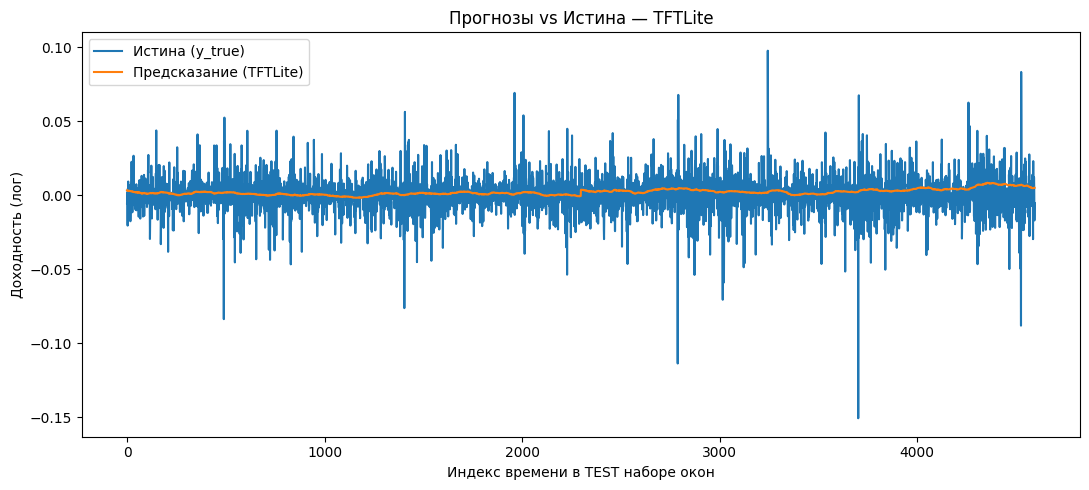

C:\Users\User\AppData\Local\Temp\ipykernel_7728\821172657.py:28: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  "time": pd.date_range(start="2000-01-01", periods=len(y_true), freq="T"),


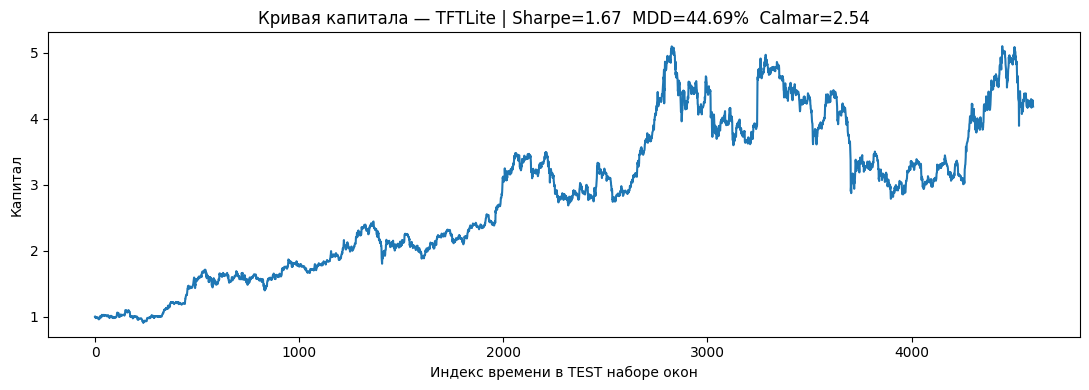

In [ ]:
# Здесь идут график и некоторые расчеты для наглядности
# берем лучшую модель
from math import isfinite


_df = pd.read_csv("benchmarks_out/benchmark_results.csv")
if "score" in _df.columns:
    best_model = _df.sort_values("score", ascending=False).iloc[0]["model"]
else:
    best_model = _df.sort_values("rmse").iloc[0]["model"]

with open("benchmarks_out/predictions.json", "r", encoding="utf-8") as f:
    preds = json.load(f)
y_true = np.array(preds[best_model]["y_true"])
y_pred = np.array(preds[best_model]["y_pred"])

plt.figure(figsize=(11,5))
plt.plot(y_true, label="Истина (y_true)")
plt.plot(y_pred, label=f"Предсказание ({best_model})")
plt.legend()
plt.title(f"Прогнозы vs Истина — {best_model}")
plt.xlabel("Индекс времени в TEST наборе окон")
plt.ylabel("Доходность (лог)")
plt.tight_layout()
plt.show()

# Мини‑пример расчёта доходности "вручную": как в метриках (с лагом и комиссиями)
meta_for_trade = {
    "y_true": y_true,
    "y_pred": y_pred,
    "time": pd.date_range(start="2000-01-01", periods=len(y_true), freq="T"),
    "sym_id": np.zeros(len(y_true), dtype=int)
}
tm = trading_metrics_portfolio(meta_for_trade, {0: "__single__"},
                              policy=cfg.policy, thresh=("auto" if cfg.thresh_kind == "auto" else cfg.thresh),
                              fee_bps=cfg.fee_bps, bars_per_year=bars_per_year, returns_kind=cfg.returns_kind)
y_true_arith = y_true if cfg.returns_kind == "arithmetic" else np.expm1(y_true)

# решение сегодня исполняется завтра: pos_prev = pos.shift(1)
if cfg.policy == "long_flat":
    pos = (y_pred>cfg.thresh).astype(float)
else:
    pos = np.sign(y_pred)
pos_prev = np.r_[0.0, pos[:-1]]
fee = cfg.fee_bps / 1e4
turn = np.abs(pos - pos_prev)
r = pos_prev * y_true_arith - turn * fee
eq = np.cumprod(1.0 + r)

plt.figure(figsize=(11,4))
plt.plot(eq)
sh, mdd, cr = tm['sharpe'], tm['mdd'], tm['calmar']
plt.title(f"Кривая капитала — {best_model} | Sharpe={sh:.2f}  MDD={mdd:.2%}  Calmar={cr if isfinite(cr) else float('inf'):.2f}")
plt.xlabel("Индекс времени в TEST наборе окон")
plt.ylabel("Капитал")
plt.tight_layout()
plt.show()
